# Assignment - Unsupervised Learning
This assignment is for Big Data in Finance II.

## 0 Setup
Download the lending club data saved on the hub as 
*/Data/lendingclub_cleaned/Loan_data.csv*.

Keep the following list of borrower characteristics:

`[loan_amnt, int_rate, annual_inc, avg_cur_bal, emp_length, fico_range_high, delinq_amnt, revol_util]`

Also keep `loan_status` and convert it into a default indicator (which is one if the loan status is "Fail")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to try tensorflow, un-comment following two lines
# import os
# os.environ['KERAS_BACKEND']='tensorflow'

from tqdm import tqdm
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input

np.seterr(all='ignore')
np.random.seed(123)

In [2]:
# load data
df = pd.read_csv('../data/lendingclub_cleaned/Loan_data.csv', low_memory = False, index_col=0)

# keep list of borrower characteristers
clist = ['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'avg_cur_bal', 'emp_length', 'fico_range_high', 'delinq_amnt', 'revol_util']
df = df[clist]

# turn loan_status into a default indicator
df['loan_status'] = (df['loan_status'] == 'Fail')

# make sure everything is numerical
for col in df.columns:
    df[col] = df[col].astype('float')
    
# inspect data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107260 entries, 126413292 to 118607680
Data columns (total 9 columns):
loan_status        107260 non-null float64
loan_amnt          107260 non-null float64
int_rate           107260 non-null float64
annual_inc         107260 non-null float64
avg_cur_bal        107260 non-null float64
emp_length         107260 non-null float64
fico_range_high    107260 non-null float64
delinq_amnt        107260 non-null float64
revol_util         107260 non-null float64
dtypes: float64(9)
memory usage: 8.2 MB


## 1 Pricipal Components
Compute the first 2 principal components.

Make a biplot and interpret the main sources of variation in the data.

In [3]:
# standardise data
X = (df - df.mean())/df.std()

In [4]:
# covariance matrix
C = np.dot(X.T,X) / (df.shape[0]-1)
C = C.astype(float)

In [5]:
# get eigenvalues and eigenvectors
e,V = np.linalg.eig(C)

In [6]:
# convert this to first two PC
Z = np.dot(X,V[:,0:2])
print (Z)

[[ 1.27733312 -2.46281446]
 [ 0.25645302  1.06507818]
 [-0.36900341 -2.55730184]
 ...
 [ 1.23981536  0.54952719]
 [-0.06702583 -0.64602478]
 [ 1.37465932  0.73040956]]


In [7]:
%%time
# for speed: use preloaded package
pca = PCA(n_components = 8)
X = (df - df.mean())/df.std()
Z = pca.fit_transform(X)
print (Z)

[[ 1.27733312  2.46281446  0.58841666 ...  0.25684065  0.79145685
  -0.27065037]
 [ 0.25645302 -1.06507818  0.35825133 ...  0.1715059   0.52492516
  -0.61443995]
 [-0.36900341  2.55730184  0.8218605  ... -0.10367955  3.06043477
  -0.52686517]
 ...
 [ 1.23981536 -0.54952719 -0.79776485 ...  0.1357662  -0.73279752
   2.66778942]
 [-0.06702583  0.64602478  1.0444469  ...  0.88203443 -0.83137729
  -0.08772295]
 [ 1.37465932 -0.73040956 -0.33948971 ... -0.90384292  0.05441268
   0.76168635]]
Wall time: 94.3 ms


In [8]:
# get loadings on 5 most common terms
loadings = pd.DataFrame(pca.components_[0:2],index=['PC1','PC2'],columns = df.columns)
terms = list(df.sum(axis=0).sort_values(ascending=False)[0:10].index)
loadings = loadings[terms] 
loadings

,annual_inc,loan_amnt,avg_cur_bal,fico_range_high,revol_util,int_rate,delinq_amnt,emp_length,loan_status
PC1,-0.025063,0.018972,-0.008218,-0.603640,0.551197,0.550476,0.015732,0.003580,0.165714
PC2,0.568919,0.526023,0.562162,0.090327,0.175567,-0.054990,0.017814,0.201678,-0.024619


Text(0,0.5,'Second principal component')

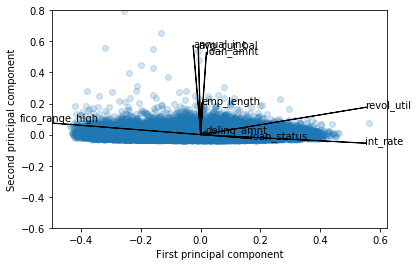

In [9]:
# biplot
# plt.figure(figsize=(10,6))
for term in terms:
    plt.arrow(0,0,loadings.loc['PC1',term],loadings.loc['PC2',term])
    plt.text(loadings.loc['PC1',term],loadings.loc['PC2',term],term)
plt.scatter(Z[:,0]/(Z[:,0].max() - Z[:,0].min()) ,Z[:,1]/(Z[:,1].max() - Z[:,1].min()),alpha = 0.2)
# plt.xlim(-0.25,1)
plt.ylim(-0.6,0.8)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

## 2 Visualize Variation
Make a table with the percentage of variance explained by q
principal components. (q = 1 to 8)

Choose suitable number of principal components used in classification.

Text(0,0.5,'Percentage of Variance Explained')

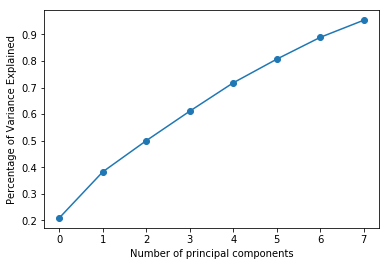

In [10]:
# scree plot
# plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlabel('Number of principal components')
plt.ylabel('Percentage of Variance Explained')

## 3 Prediction
Reallocate the dataset into 80% traning set, 10% validation set, 10% test set.
Create a synthetic dataset by undersampling non-defaulters(<70%).

Run 8 logistic classifiers that predict default as a function of the first q principal components.

In [11]:
# set up data for classification
# class label: default
y = df['loan_status'].values.reshape(1, -1)
print(y.shape)

# features: the remaining columns
X = df.drop(columns='loan_status').values.T

# standardise inputs
X = (X - np.mean(X, axis=1).reshape(-1, 1)) / np.std(X, axis=1).reshape(-1, 1)
print(X.shape)

(1, 107260)
(8, 107260)


In [15]:
# reallocate dataset
X_train, X_test, y_train, y_test = \
cross_validation.train_test_split(X.T, y.T, test_size = 0.8, random_state = 0)

In [16]:
# sigmoid function
def sigmoid(A):
    return 1/(1+np.exp(-A))

# baby backprop
def babybackprop(X,y,W):
    
    # forward pass to get prediction
    A = np.dot(W,X)
    yhat = sigmoid(A)
    
    # derivative of loss with respect to a
    dA = yhat - y
    
    # average derivative of loss with respect to W
    grad = np.matmul(dA,X.T) / X.shape[1]

    return grad

# cross entropy loss
def cross_entropy(yhat,y):
    L = - y * np.log(yhat) - (1-y) * np.log(1-yhat)
    loss = np.sum(L) / yhat.shape[1]
    return loss

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 87.71it/s]


Text(0,0.5,'Loss')

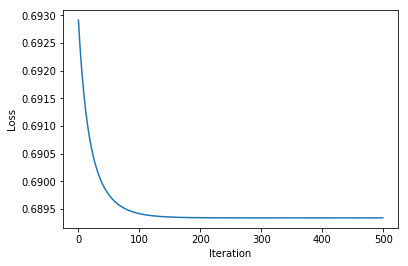

In [17]:
# logit initialisation
p = X.shape[0]
W = np.random.rand(1,p) * 0.01

# learning rate
learning_rate = 0.1

# number of steps for gradient descent
steps = 500

# initialize list to hold losses over time
losses_logit = []

for i in tqdm(range(steps)):
    
    # get gradients using baby backprop
    grad = babybackprop(X,y,W)
    
    # update parameters using gradient descent
    W -= learning_rate * grad
    
    # cross-entropy loss
    A = np.dot(W,X)
    yhat = sigmoid(A)
    loss = cross_entropy(yhat,y)
    losses_logit.append(loss)

# visualise learning over time
plt.plot(range(steps),losses_logit)    
plt.xlabel('Iteration')
plt.ylabel('Loss')

## 4 Tune Parameter
Get implied probabilities of default of all borrowers in validation set.

Use these predictions and actual outcomes to calculate the cross-entropy loss for each q.

Choose q which has the lowest loss on validation set. Evaluate performance of model on test set.

## 5 Alternatives to PCA
Pseudocode for backprop and gradient descent, for a nonlinear q-dimensional representation of consumer characteristics that uses <u>autoencoder</u>. [Goodfellow et al., Ch.14](https://www.deeplearningbook.org/contents/autoencoders.html)

Train this model, get insights relative to PCA.

In [29]:
# set up data for classification
# class label: default
y = df['loan_status'].values.reshape(1,-1)
print(y.shape)

# features: the remaining columns
X = df.drop(columns = 'loan_status').values.T

# standardise inputs
X = (X - np.mean(X,axis=1).reshape(-1,1)) / np.std(X,axis=1).reshape(-1,1)
print(X.shape)

(1, 107260)
(8, 107260)


In [ ]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(107260,))

# encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(107260, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(inputs=input_img, outputs=decoded)

# construct the encoder model for plotting
encoder = Model(inputs=input_img, outputs=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')


In [30]:
# training
autoencoder.fit(X, X,
                epochs=20,
                batch_size=256,
                shuffle=True)

Epoch 1/20
8/8 [==============================] - 1s 65ms/step - loss: 0.5807
Epoch 2/20
8/8 [==============================] - 1s 65ms/step - loss: 0.5724
Epoch 3/20
8/8 [==============================] - 1s 91ms/step - loss: 0.5658
Epoch 4/20
8/8 [==============================] - 1s 91ms/step - loss: 0.5590
Epoch 5/20
8/8 [==============================] - 1s 72ms/step - loss: 0.5515
Epoch 6/20
8/8 [==============================] - 1s 89ms/step - loss: 0.5445
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 0.5366
Epoch 8/20
8/8 [==============================] - 1s 69ms/step - loss: 0.5297
Epoch 9/20
8/8 [==============================] - 1s 81ms/step - loss: 0.5222
Epoch 10/20
8/8 [==============================] - 1s 81ms/step - loss: 0.5150
Epoch 11/20
8/8 [==============================] - 1s 67ms/step - loss: 0.5088
Epoch 12/20
8/8 [==============================] - 1s 78ms/step - loss: 0.5026
Epoch 13/20
8/8 [==============================] - 1s 64ms/st

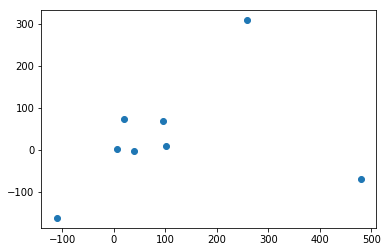

In [21]:
# plotting
encoded_imgs = encoder.predict(X)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1]) # something wrong here
# plt.show()

## 6 K-Means Clustering
Cluster borrowers into K groups using K-means.

In [22]:
# auxiliary functions
def get_means(labels,X,k):
    means = np.zeros((k,X.shape[1]))
    for c in range(k):
        points = X[labels == c]
        means[c,:] = points.mean(axis=0)
    return means
        

# auxiliary function for assigning closest centroids
def get_closest(means,X,k):
    distances = np.zeros((X.shape[0],k))
    for c in range(k):
        diff = X.values - means[c,:]
        distances[:,c] = np.linalg.norm(diff,axis=1)**2
        
    labels = np.argmin(distances,axis=1)
    min_distance = np.min(distances,axis=1)
    
    return labels, min_distance

In [23]:
# set up data for classification
# class label: default
y = df['loan_status']
print(y.shape)

# features: the remaining columns
X = df.drop(columns = 'loan_status')
print(X.shape)

(107260,)
(107260, 8)


In [24]:
k=3
means = X.sample(k,random_state = 123).values
labels, _ = get_closest(means,X,k)
get_closest(means,X,k)

for i in range(100):
    means = get_means(labels,X,k)
    new_labels, min_distance = get_closest(means,X,k)
    if (labels == new_labels).all(): 
        break
    else: 
        labels = new_labels

Text(0,0.5,'Second principal component of returns')

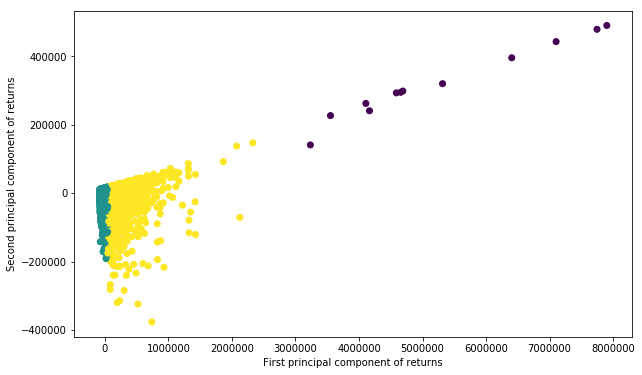

In [25]:
# visualisation
Z = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(Z[:,0],Z[:,1],c=labels)
plt.xlabel('First principal component of returns')
plt.ylabel('Second principal component of returns')

## 7 Tune Paramerter
Design a graphical tool that helps pick good number of K.

Interpret characteristics
of borrowers in each cluster.

Text(0,0.5,'Within-cluster point scatter')

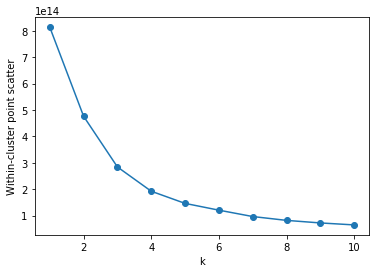

In [26]:
# for speed, use pre-loaded package
distances = []
for k in range(1,11): 
    fitted = KMeans(n_clusters=k,random_state = 234,n_init=10).fit(X)
    distances.append(fitted.inertia_)
plt.plot(range(1,11),distances,'-o')    
plt.xlabel('k')
plt.ylabel('Within-cluster point scatter')

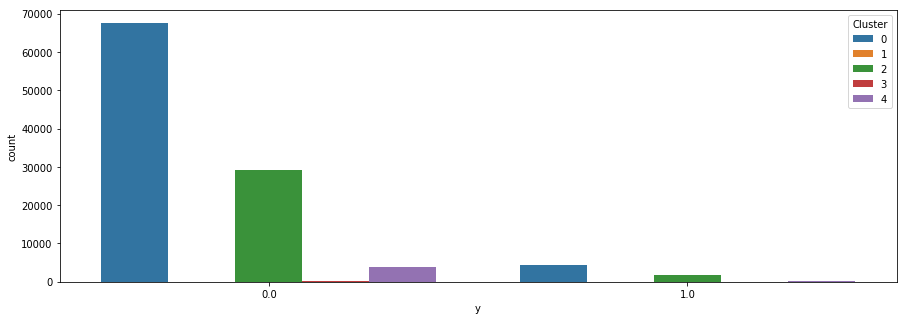

In [27]:
# what are we picking up?
labels = KMeans(n_clusters = 5).fit_predict(X)
plt.figure(figsize=(15,5))
sns.countplot(y.values,hue=labels)
plt.xlabel('y')
plt.legend(title='Cluster')